**MovieLens DATASET**

*The MovieLens 20M Dataset, provided by
GroupLens, a research lab in the Department of Computer Science and
Engineering at the University of Minnesota, Twin Cities. The data contains
20,000,263 ratings across 27,278 movies created by 138,493 users from
January 9, 1995 to March 31, 2015. Of users who rated at least 20 movies
each, we will select a subset at random.
This dataset is more manageable to work with than the 100 million ratings
dataset from Netflix. Because the file size exceeds one hundred megabytes,
the file is not accessible on GitHub. You will need to download the file
directly from the MovieLens website.*

**DATA PREPARATION**

In [1]:
'''Main Libraries'''
import numpy as np
import pandas as pd
import os, time, re
import datetime

In [3]:
'''Data Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
color = sns.color_palette()
%matplotlib inline

In [4]:
'''Data Preparation and Model Evaluation'''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

In [5]:
'''Algorithm'''
import lightgbm as lgb

In [6]:
'''Tensorflow and Keras'''
import  tensorflow as tf

import keras
from keras import backend as k

from keras.models import Sequential, Model

from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda

from keras import regularizers

from keras.losses import mse, binary_crossentropy

**IMPORT DATASET**

In [7]:
df = pd.read_csv("..\\Restricted Boltzmann Machine\\movielens_data\\rating.csv")

In [8]:
df.head(4)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07


**PERFORM EXPLORATORY DATA ANALYSIS**

In [12]:
num_of_user = df['userId'].unique().shape[0]
num_of_movies = df['movieId'].unique().shape[0]
num_of_ratings = len(df)
average_rating_per_user = num_of_ratings/num_of_user

print(f'Number of unique users: {num_of_user}')
print(f'Number of unique movies: {num_of_movies}')
print(f'Number of total ratings: {num_of_ratings}')
print(f'Average number of ratings per user: {round(average_rating_per_user,1)}')

Number of unique users: 138493
Number of unique movies: 26744
Number of total ratings: 20000263
Average number of ratings per user: 144.4


*To reduce the complexity and size of this dataset, let’s focus on the top one
thousand most rated movies. This will reduce the number of ratings from
about ~20 million to about ~12.8 million.*

**REDUCE THE SIZE OF THE DATASET BY TAKING THE TOP 1000 MOVIES**

In [14]:
movie_index = df.groupby("movieId").count().sort_values(by="rating",ascending=False)[0:1000].index
reduced_df = df[df.movieId.isin(movie_index)]
reduced_df.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

**REDUCE THE SIZE OF THE DATASET BY SAMPLING 1000 USERS**

In [16]:
# Reduce size of dataset by sampling 1000 users
user_index = reduced_df.groupby("userId").count().sort_values(by="rating",ascending=False).sample(n=1000, random_state=2018).index
reduced_df_one = reduced_df[reduced_df.userId.isin(user_index)]
reduced_df_one.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

**RE-INDEX MOVIE ID AND USER ID**

In [19]:
# Reindex movie ID
movies = reduced_df_one.movieId.unique()
movies_df = pd.DataFrame(data=movies,columns=['originalMovieId'])
movies_df['newMovieId'] = movies_df.index+1

# Reindex user ID
users = reduced_df_one.userId.unique()
users_df = pd.DataFrame(data=users,columns=['originalUserId'])
users_df['newUserId'] = users_df.index+1

In [20]:
movies_df.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


In [21]:
users_df.head()

,originalUserId,newUserId
0,49,1
1,260,2
2,311,3
3,319,4
4,499,5


**GENERATE A NEW DATAFRAME**

In [22]:
new_df = reduced_df_one.merge(movies_df,left_on='movieId', right_on='originalMovieId')
new_df.drop(labels='originalMovieId', axis=1, inplace=True)
new_df = new_df.merge(users_df,left_on='userId', right_on='originalUserId')
new_df.drop(labels='originalUserId', axis=1, inplace=True)

In [23]:
new_df.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1


**SAVE THE NEW DATAFRAME**

In [24]:
new_df.to_csv('reduced_movie_dataset.csv', sep=',', index=False, encoding='utf-8')

**CALCULATE THE SUMMARY OF NEW DATASET**

In [25]:
num_of_user = new_df['userId'].unique().shape[0]
num_of_movies = new_df['movieId'].unique().shape[0]
num_of_ratings = len(new_df)
average_rating_per_user = num_of_ratings/num_of_user

print(f'Number of unique users: {num_of_user}')
print(f'Number of unique movies: {num_of_movies}')
print(f'Number of total ratings: {num_of_ratings}')
print(f'Average number of ratings per user: {round(average_rating_per_user,1)}')

Number of unique users: 1000
Number of unique movies: 1000
Number of total ratings: 90213
Average number of ratings per user: 90.2


**PERFORM TRAIN TEST SPLIT**

In [26]:
X_train, X_test = train_test_split(new_df, test_size=0.10, shuffle=True, random_state=2018)

In [27]:
X_valid, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

In [28]:
X_train

,userId,movieId,rating,timestamp,newMovieId,newUserId
77796,118358,2918,4.0,2005-03-17 13:11:50,725,841
20109,48345,1907,3.0,2003-01-26 05:32:21,345,347
61046,25880,74458,4.0,2010-11-21 09:47:32,75,180
58074,73713,39,4.0,1999-02-07 05:07:01,465,522
77706,117584,590,4.0,1996-09-11 08:24:35,255,831
...,...,...,...,...,...,...
10388,27131,52,5.0,2000-07-03 18:02:48,634,195
40092,108946,2028,4.0,2001-01-31 05:48:49,57,769
84745,32312,5299,4.0,2005-03-27 06:42:32,380,243
80098,93974,508,5.0,2003-01-20 07:06:12,39,654


In [29]:
X_valid

,userId,movieId,rating,timestamp,newMovieId,newUserId
58632,104102,3578,5.0,2013-09-29 11:54:04,234,731
6501,20257,1284,4.0,1997-02-06 01:18:50,861,137
45799,125007,2959,5.0,2008-03-28 19:43:53,64,893
7180,20579,5218,4.0,2005-03-05 19:56:49,379,145
143,311,546,1.0,2001-02-18 16:09:41,115,3
...,...,...,...,...,...,...
59794,7598,457,4.0,2001-09-30 13:34:42,305,55
62199,29357,165,3.0,2005-05-21 23:05:21,87,219
22193,52868,357,3.0,2004-11-23 12:36:10,300,380
9009,25676,10,3.5,2006-04-10 19:55:28,79,177


In [30]:
X_test

,userId,movieId,rating,timestamp,newMovieId,newUserId
3750,9563,480,3.0,1996-06-25 21:47:44,112,76
31667,84140,1682,4.0,2007-07-22 07:28:53,54,579
38850,103394,1517,1.0,1999-12-12 16:08:19,569,725
78158,132306,1214,3.0,2000-08-03 18:12:49,139,945
57372,63228,2161,0.5,2004-10-11 18:51:37,349,447
...,...,...,...,...,...,...
29023,74390,858,5.0,2003-06-20 17:42:12,124,524
20492,50130,2355,5.0,2006-04-26 03:25:44,354,360
63676,46868,500,4.0,1996-09-28 16:40:56,306,334
88115,108303,858,5.0,1997-06-20 04:52:27,124,764


In [31]:
# Confirm size of train, validation, and test datasets
for (l,x) in [('train',X_train),('validation',X_valid),('test',X_test)]:
    print(f'Size of {l} set: {len(x)}')

Size of train set: 81191
Size of validation set: 4511
Size of test set: 4511


**Define the Cost Function: Mean Squared Error**

*First, let’s create a matrix m x n, where m are the users and n are the movies.
This will be a sparsely populated matrix because users rate only a fraction of
the movies. For example, a matrix with one thousand users and one thousand
movies will have only 81,191 ratings in the training set. If each of the one
thousand users rated each of the one thousand movies, we would have a
matrix with one million ratings, but users rate only a small subset of movies
on average, so we have only 81,191 ratings on the training set. The rest
(nearly 92% of the values in the matrix) will be zeros:*

In [39]:
# Generate ratings matrix for train
ratings_train = np.zeros((num_of_user, num_of_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

# Calculate sparsity of the train ratings matrix
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print(f'Sparsity: {round(sparsity,2)}')

Sparsity: 8.12


In [40]:
print(f'Train Rating: {ratings_train}')

Train Rating: [[5.  3.5 0.  ... 0.  0.  0. ]
 [4.  0.  0.  ... 0.  0.  0. ]
 [5.  3.  0.  ... 0.  0.  0. ]
 ...
 [0.  4.  0.  ... 0.  0.  0. ]
 [4.  2.  1.5 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


In [43]:
# Generate ratings matrix for validation
ratings_validation = np.zeros((num_of_user, num_of_movies))
for row in X_valid.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]
    
# Generate ratings matrix for test
ratings_test = np.zeros((num_of_user, num_of_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

In [44]:
ratings_validation

array([[0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
ratings_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
# flatten the sparse matrix with the ratings for the validation set.
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [48]:
actual_validation

array([3., 1., 3., ..., 3., 3., 4.])

**Perform Baseline Experiments**

*As a baseline, let’s predict an average rating of 3.5 for the validation set and
calculate the MSE:*

In [49]:
pred_validation = np.zeros((len(X_valid),1))
pred_validation[pred_validation==0] = 3.5
pred_validation
mean_squared_error(pred_validation, actual_validation)

1.055420084238528

*The MSE of this very naive prediction is 1.05. This is our baseline:
Mean squared error using naive prediction: 1.055420084238528
Let’s see if we can improve our results by predicting a user’s rating for a
given movie based on that user’s average rating for all other movies:*

In [53]:
ratings_validation_prediction = np.zeros((num_of_user, num_of_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1
    
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)

In [54]:
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 0.9090717929472647


*Now, let’s predict a user’s rating for a given movie based on the average
rating all other users have given that movie:*

In [56]:
ratings_validation_prediction = np.zeros((num_of_user, num_of_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1
    
ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)

In [57]:
print('Mean squared error using movie average:', movie_average)

Mean squared error using movie average: 0.9136057106858655


**RECCOMENDER SYSTEMS USING MATRIX FACTORIZATION**

**Matrix Factorization**

*Before we build a recommender system using RBMs, let’s first build one
using matrix factorization, one of the most successful and popular
collaborative filtering algorithms today. Matrix factorization decomposes the
user-item matrix into a product of two lower dimensionality matrices. Users
are represented in lower dimensional latent space, and so are the items.
Assume our user-item matrix is R, with m users and n items. Matrix
factorization will create two lower dimensionality matrices, H and W. H is
an "m users” x "k latent factors” matrix, and W is a "k latent factors” x "n
items” matrix.
The ratings are computed by matrix multiplication: R = H__W.
The number of k latent factors determines the capacity of the model. The
higher the k, the greater the capacity of the model. By increasing k, we can
improve the personalization of rating predictions for users, but, if k is too
high, the model will overfit the data.
All of this should be familiar to you. Matrix factorization learns
representations for the users and items in a lower dimensional space and
makes predictions based on the newly learned representations.*

*Let’s start with the simplest form of matrix factorization—with just one latent
factor. We will use Keras to perform our matrix factorization.
First, we need to define the graph. The input is the one-dimensional vector of
users for the user embedding and the one-dimensional vector of movies for
the movie embedding. We will embed these input vectors into a latent space
of one and then flatten them. To generate the output vector product, we will
take the dot product of the movie vector and user vector. We will use the
Adam optimizer to minimize our cost fuction, which is defined as the
mean_squared_error:*

**ONE LATENT FACTOR**

In [60]:
from tensorflow.keras.layers import Embedding, Flatten, dot
# One Latent Factor
n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=num_of_user + 1,
output_dim=n_latent_factors,
name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=num_of_movies + 1,
output_dim=n_latent_factors,
name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [63]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, 
                    epochs=100,
                    validation_data=([X_valid.newUserId,X_valid.newMovieId], X_valid.rating),
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 9s 3ms/step - loss: 13.6474 - val_loss: 11.9207
Epoch 2/100
2538/2538 [==============================] - 7s 3ms/step - loss: 9.2010 - val_loss: 6.5944
Epoch 3/100
2538/2538 [==============================] - 7s 3ms/step - loss: 4.6876 - val_loss: 3.3795
Epoch 4/100
2538/2538 [==============================] - 7s 3ms/step - loss: 2.5765 - val_loss: 2.0776
Epoch 5/100
2538/2538 [==============================] - 8s 3ms/step - loss: 1.6621 - val_loss: 1.4577
Epoch 6/100
2538/2538 [==============================] - 8s 3ms/step - loss: 1.2097 - val_loss: 1.1461
Epoch 7/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.9801 - val_loss: 0.9840
Epoch 8/100
2538/2538 [==============================] - 8s 3ms/step - loss: 0.8618 - val_loss: 0.8975
Epoch 9/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.7999 - val_loss: 0.8522
Epoch 10/100
2538/2538 [==============================] - 7s 3ms/step -

Minimum MSE:  0.7959693074226379


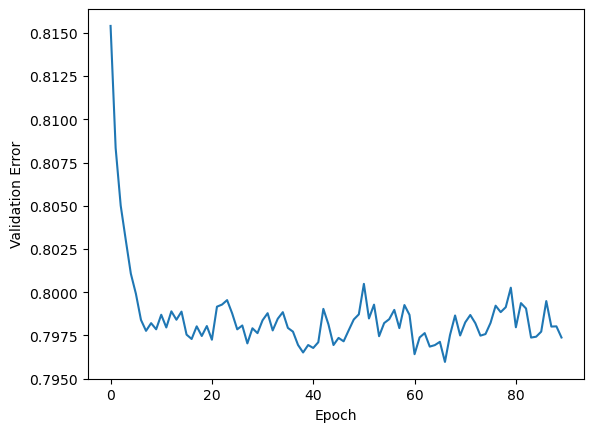

In [65]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

*The minimum MSE using matrix factorization and one latent factor is 0.796.
This is a better MSE than our user average and movie average approaches
from earlier.*

**THREE LATENT FACTOR**

In [66]:
n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=num_of_user + 1,
output_dim=n_latent_factors,
name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=num_of_movies + 1,
output_dim=n_latent_factors,
name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [67]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, 
                    epochs=100,
                    validation_data=([X_valid.newUserId,X_valid.newMovieId], X_valid.rating),
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 10s 3ms/step - loss: 12.9492 - val_loss: 9.0668
Epoch 2/100
2538/2538 [==============================] - 7s 3ms/step - loss: 5.1132 - val_loss: 2.7876
Epoch 3/100
2538/2538 [==============================] - 8s 3ms/step - loss: 1.9109 - val_loss: 1.4337
Epoch 4/100
2538/2538 [==============================] - 8s 3ms/step - loss: 1.1169 - val_loss: 1.0172
Epoch 5/100
2538/2538 [==============================] - 8s 3ms/step - loss: 0.8650 - val_loss: 0.8792
Epoch 6/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.7812 - val_loss: 0.8286
Epoch 7/100
2538/2538 [==============================] - 8s 3ms/step - loss: 0.7522 - val_loss: 0.8100
Epoch 8/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.7421 - val_loss: 0.8007
Epoch 9/100
2538/2538 [==============================] - 8s 3ms/step - loss: 0.7381 - val_loss: 0.8011
Epoch 10/100
2538/2538 [==============================] - 7s 3ms/step -

Minimum MSE:  0.7593799829483032


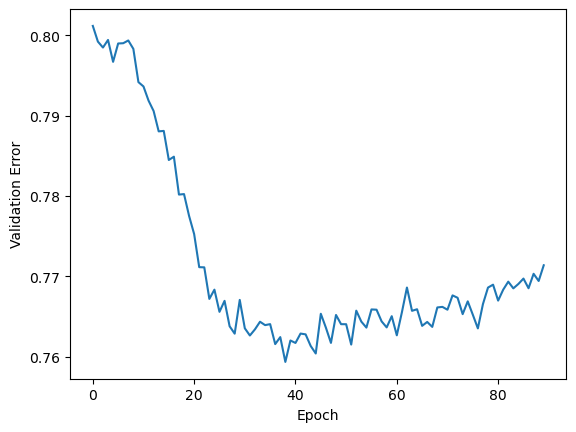

In [68]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

**FIVE LATENT FACTOR**

In [69]:
n_latent_factors = 5

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=num_of_user + 1,
output_dim=n_latent_factors,
name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=num_of_movies + 1,
output_dim=n_latent_factors,
name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [70]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, 
                    epochs=100,
                    validation_data=([X_valid.newUserId,X_valid.newMovieId], X_valid.rating),
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 10s 3ms/step - loss: 11.7004 - val_loss: 6.0312
Epoch 2/100
2538/2538 [==============================] - 7s 3ms/step - loss: 3.1151 - val_loss: 1.7479
Epoch 3/100
2538/2538 [==============================] - 8s 3ms/step - loss: 1.2536 - val_loss: 1.0376
Epoch 4/100
2538/2538 [==============================] - 9s 4ms/step - loss: 0.8701 - val_loss: 0.8667
Epoch 5/100
2538/2538 [==============================] - 9s 3ms/step - loss: 0.7752 - val_loss: 0.8217
Epoch 6/100
2538/2538 [==============================] - 9s 4ms/step - loss: 0.7505 - val_loss: 0.8053
Epoch 7/100
2538/2538 [==============================] - 8s 3ms/step - loss: 0.7375 - val_loss: 0.8003
Epoch 12/100
2538/2538 [==============================] - 8s 3ms/step - loss: 0.7366 - val_loss: 0.7963
Epoch 13/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.7344 - val_loss: 0.7978
Epoch 14/100
2538/2538 [==============================] - 9s 4ms/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2538/2538 [==============================] - 8s 3ms/step - loss: 0.5474 - val_loss: 0.7636
Epoch 82/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.5472 - val_loss: 0.7659
Epoch 83/100
2538/2538 [==============================] - 8s 3ms/step - loss: 0.5470 - val_loss: 0.7689
Epoch 84/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.5468 - val_loss: 0.7677
Epoch 85/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.5440 - val_loss: 0.7736
Epoch 95/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.5440 - val_loss: 0.7705
Epoch 96/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.5440 - val_loss: 0.7748
Epoch 97/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.5437 - val_loss: 0.7749
Epoch 98/100
2538/2538 [==============================] - 8s 3ms/step - loss: 0.5435 - val_loss: 0.7736
Epoch 99/100
2538/2538 [==============================] - 7s 3ms/step - loss:

Minimum MSE:  0.74566251039505


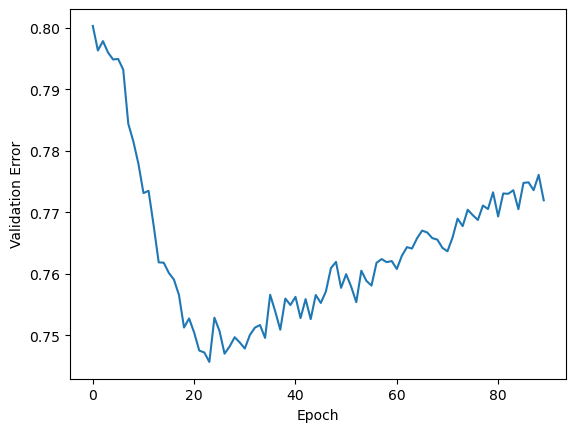

In [71]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

**Collaborative Filtering Using RBMs**

*Let’s turn back to RBMs again. Recall that RBMs have two layers—the
input/visible layer and the hidden layer. The neurons in each layer
communicate with neurons in the other layer but not with neurons in the same
layer. In other words, there is no intralayer communication among the
neurons—this is the restricted bit of RBMs.


Another important feature of RBMs is that the communication between layers
happens in both directions—not just in one direction. For example, with
autoencoders, the neurons communicate with the next layer, passing
information only in a feedforward way.


With RBMs, the neurons in the visible layer communicate with the hidden
layer, and then the hidden layer passes back information to the visibile layer,
going back and forth several times. RBMs perform this communication—the
passes back and forth between the visible and hidden layer—to develop a
generative model such that the reconstructions from the outputs of the hidden
layer are similar to the original inputs.


In other words, the RBMs are trying to create a generative model that will
help predict whether a user will like a movie that the user has never seen
based on how similar the movie is to other movies the user has rated and
based on how similar the user is to the other users that have rated that movie.
The visible layer will have X neurons, where X is the number of movies in
the dataset. Each neuron will have a normalized rating value from zero to
one, where zero means the user has not seen the movie. The closer the
normalized rating value is to one, the more the user likes the movie
represented by the neuron.


The neurons in the visible layer will communicate with the neurons in the
hidden layer, which will try to learn the underlying, latent features that
characterize the user-movie preferences.
Note that RBMs are also referred to as symmetrical bipartite, bidirectional
graphs—symmetrical because each visible node is connected to each hidden
node, bipartite because there are two layers of nodes, and bidirectional
because the communication happens in both directions.*

**RBM Neural Network Architecture**

*For our movie-recommender system, we have an m x n matrix with m users
and n movies. To train the RBM, we pass along a batch of k users with their
n movie ratings into the neural network and train for a certain number of
epochs.
                                                 
Each input x that is passed into the neural network represents a single user’s
rating preferences for all n movies, where n is one thousand in our example.
Therefore, the visible layer has n nodes, one for each movie.
    
We can specify the number of nodes in the hidden layer, which will generally
be fewer than the nodes in the visible layer to force the hidden layer to learn
the most salient aspects of the original input as efficiently as possible.
Each input v0 is multiplied by its respective weight W. 

The weights are learned by the connections from the visible layer to the hidden layer. Then
we add a bias vector at the hidden layer called hb. The bias ensures that at
least some of the neurons fire. This W*v0+hb result is passed through an
activation function.
    
After this, we will take a sample of the outputs generated via a process
known as Gibbs sampling. In other words, the activation of the hidden layer
results in final outputs that are generated stochastically. This level of
randomness helps build a better-performing and more robust generative
model.

Next, the output after Gibbs sampling—known as h0—is passed back through
the neural network in the opposite direction in what is called a backward
pass. In the backward pass, the activations in the forward pass after Gibbs
sampling are fed into the hidden layer and multiplied by the same weights W
as before. We then add a new bias vector at the visible layer called vb.
This W_h0+vb is passed through an activation function, and then we perform
Gibbs sampling. The output of this is v1, which is then passed as the new
input into the visible layer and through the neural network as another forward
pass.

The RBM goes through a series of forward and backward passes like this to
learn the optimal weights as it attempts to build a robust generative model.
RBMs are the first type of generative learning model that we have explored.
By performing Gibbs sampling and retraining weights via forward and
backward passes, RBMs are trying to learn the probability distribution of
the original input. Specifically, RBMs minimize the Kullback–Leibler
divergence, which measures how one probability distribution is different
from another; in this case, RBMs are minimizing the probability distribution
of the original input from the probability distribution of the reconstructed
data.

By iteratively readjusting the weights in the neural net, the RBM learns to
approximate the original data as best as possible.
With this newly learned probability distribution, RBMs are able to make
predictions about never-before-seen data. In this case, the RBM we design
will attempt to predict ratings for movies that the user has never seen based
on the user’s similarity to other users and the ratings those movies have
received by the other users.*

**Build the Components of the RBM Class**

*First, we will initialize the class with a few parameters; these are the input
size of the RBM, the output size, the learning rate, the number of epochs to
train for, and the batch size during the training process.
We will also create zero matrices for the weight matrix, the hidden bias
vector, and the visible bias vector:
                                 
Next, let’s define functions for the forward pass, the backward pass, and the
sampling of data during each of these passes back and forth.
Here is the forward pass, where h is the hidden layer and v is the visible
layer:
    
Now we need a function that performs that training. Since we are using
TensorFlow, we first need to create placeholders for the TensorFlow graph,
which we will use when we feed data into the TensorFlow session.
We will have placeholders for the weights matrix, the hidden bias vector, and
the visible bias vector. We will also need to initialize the values for these
three using zeros. And, we will need one set to hold the current values and
one set to hold the previous values:
                                                            
Likewise, we need a placeholder for the visible layer. The hidden layer is
derived from matrix multiplication of the visible layer and the weights matrix
and the matrix addition of the hidden bias vector:

During the backward pass, we take the hidden layer output, multiply it with
the transpose of the weights matrix used during the forward pass, and add the
visible bias vector. Note that the weights matrix is the same during both the
forward and the backward pass. Then, we perform the forward pass again:

With this, we are ready to initialize the TensorFlow session with the
variables we have just defined.
Once we call sess.run, we can feed in batches of data to begin the training.
During the training, forward and backward passes will be made, and the
RBM will update weights based on how the generated data compares to the
original input. We will print the reconstruction error from each epoch.*

In [ ]:
# Make code compatible with v1 of TF
tf.compat.v1.disable_eager_execution()

In [ ]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.compat.v1.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.compat.v1.placeholder(tf.float32, [self._output_size])
        _vb = tf.compat.v1.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.compat.v1.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.cast(tf.shape(v0)[0], tf.float32)
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

**Train RBM Recommender System**

*To train the RBM, let’s create a NumPy array called inputX from
ratings_train and convert these values to float32. We will also define the
RBM to take in a one thousand-dimensional input, output a one thousanddimensional
output, use a learning rate of 0.3, train for five hundred epochs,
and use a batch size of two hundred. These parameters are just preliminary
parameter choices; you should be able to find more optimal parameters with
experimentation, which is encouraged:*

In [ ]:
# Begin the training cycle

# Convert inputX into float32
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm = RBM(1000,1000,0.3,500,200)

In [ ]:
# Train RBM model
rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

*The error terms generally decrease the longer we train.
Now let’s take the RBM model we developed to predict the ratings for users
in the validation set (which has the same users as the training set):*

In [ ]:
# Predict ratings for validation set
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)
finalOutput_validation, reconstructedOutput_validation, _ = rbm.rbm_output(inputValidation)

*Next, let’s convert the predictions into an array and calculate the MSE
against the true validation ratings:*

In [ ]:
predictionsArray = reconstructedOutput_validation
pred_validation = predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()
rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)